In [35]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt

In [36]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layer):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_hidden_layer-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(0, np.sqrt(2/len(param)))

In [37]:
d=150528
k=1000
hidden_units=500
num_hidden_layers=8

In [38]:
model=NeuralNet(d,hidden_units,k,num_hidden_layers)
    
ReLU_init(model)

In [39]:
P_1=-np.ones(d)
P_2=np.ones(d)
x=torch.from_numpy(np.array([P_1+(P_2-P_1)*x for x in np.linspace(0,1,100)])).float()
y_max=[torch.max(torch.abs(ten)).detach().numpy() for ten in model(x)]
y_mean=[torch.mean(ten).detach().numpy() for ten in model(x)]

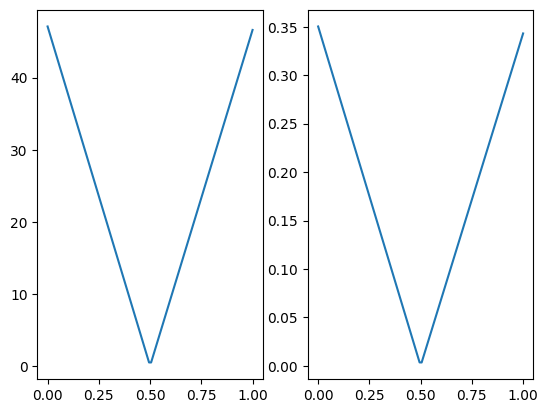

In [41]:
fig, axs = plt.subplots(1,2)
axs[0].plot(np.linspace(0,1,100),y_max)
axs[1].plot(np.linspace(0,1,100),y_mean)